<a href="https://www.kaggle.com/code/sabyasachi96/tps-july-simple-sarima-model?scriptVersionId=182961607" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Importing Libraries and **Data files**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('../input/tabular-playground-series-jul-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-jul-2021/test.csv')

In [3]:
print("train shape", train.shape)
print("test shape", test.shape)

train shape (7111, 12)
test shape (2247, 9)


# Data Analysis

Steps in data analysis will follow these following steps

* Check out categorical and numerical data
* Check for duplicate data
* Detect Null values 
* Explore the data with graphs and plots 
* Buiild model and predict







## Generic data analysis 
like **Null-Value**; **Data Types**; **Duplicate Data**

In [4]:
print("train shape", train.shape)
train.describe().T

train shape (7111, 12)


,count,mean,std,min,25%,50%,75%,max
deg_C,7111.0,20.878034,7.937917,1.3000,14.9000,20.7000,25.80000,46.100
relative_humidity,7111.0,47.561004,17.398731,8.9000,33.7000,47.3000,60.80000,90.800
absolute_humidity,7111.0,1.110309,0.398950,0.1988,0.8559,1.0835,1.40415,2.231
sensor_1,7111.0,1091.572100,218.537554,620.3000,930.2500,1060.5000,1215.80000,2088.300
sensor_2,7111.0,938.064970,281.978988,364.0000,734.9000,914.2000,1124.10000,2302.600
sensor_3,7111.0,883.903305,310.456355,310.6000,681.0500,827.8000,1008.85000,2567.400
sensor_4,7111.0,1513.238349,350.180310,552.9000,1320.3500,1513.1000,1720.40000,2913.800
sensor_5,7111.0,998.335565,381.537695,242.7000,722.8500,928.7000,1224.70000,2594.600
target_carbon_monoxide,7111.0,2.086219,1.447109,0.1000,1.0000,1.7000,2.80000,12.500
target_benzene,7111.0,10.237083,7.694426,0.1000,4.5000,8.5000,14.20000,63.700


In [5]:
print('Data types of the columns \n\n', train.info())
print('\n\n\n Total Null values\n', train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7111 entries, 0 to 7110
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date_time               7111 non-null   object 
 1   deg_C                   7111 non-null   float64
 2   relative_humidity       7111 non-null   float64
 3   absolute_humidity       7111 non-null   float64
 4   sensor_1                7111 non-null   float64
 5   sensor_2                7111 non-null   float64
 6   sensor_3                7111 non-null   float64
 7   sensor_4                7111 non-null   float64
 8   sensor_5                7111 non-null   float64
 9   target_carbon_monoxide  7111 non-null   float64
 10  target_benzene          7111 non-null   float64
 11  target_nitrogen_oxides  7111 non-null   float64
dtypes: float64(11), object(1)
memory usage: 666.8+ KB
Data types of the columns 

 None



 Total Null values
 date_time                 0
deg_C      

In [6]:
print('Total Duplicate values\n', train.duplicated().sum())

Total Duplicate values
 0


### *Inference* 1: 
* No Null values
* All except time are continuous variables of float type data
* I will change the Date-Time from string to date format
* Predcitions can be a forecast or forecasting methods like -
 * *Simple Univariate time series*
 * *Multivariate time series*
 * *Regression model, since the target is a continuous variable*

# Time Analysis:  

## Loading and preparing the data

In [7]:
# date time has to be change from object to a datetine format, this can be directly done also while importing the data
train['date_time']=pd.to_datetime(train['date_time'])
train.set_index('date_time', inplace = True)

# dataset for univariate analysis
train_u = train.copy()
cols = ['deg_C', 'relative_humidity', 'absolute_humidity',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']
train_u.drop(cols, axis = 1, inplace = True)

#renaming the columns
# cm - carbon monoxide; ben = benzene; no = nitrogen oxides
train_u.columns = ["cm", "ben", "no"]

train_u.head()


,cm,ben,no
date_time,,,
2010-03-10 18:00:00,2.5,12.0,167.7
2010-03-10 19:00:00,2.1,9.9,98.9
2010-03-10 20:00:00,2.2,9.2,127.1
2010-03-10 21:00:00,2.2,9.7,177.2
2010-03-10 22:00:00,1.5,6.4,121.8


## Visualize the data
So we have hourly data from 10th march to 1st jan next year. 
* we can extract information or trend based on month, week, day, and hourly 

array([[<AxesSubplot:xlabel='date_time'>],
       [<AxesSubplot:xlabel='date_time'>],
       [<AxesSubplot:xlabel='date_time'>]], dtype=object)

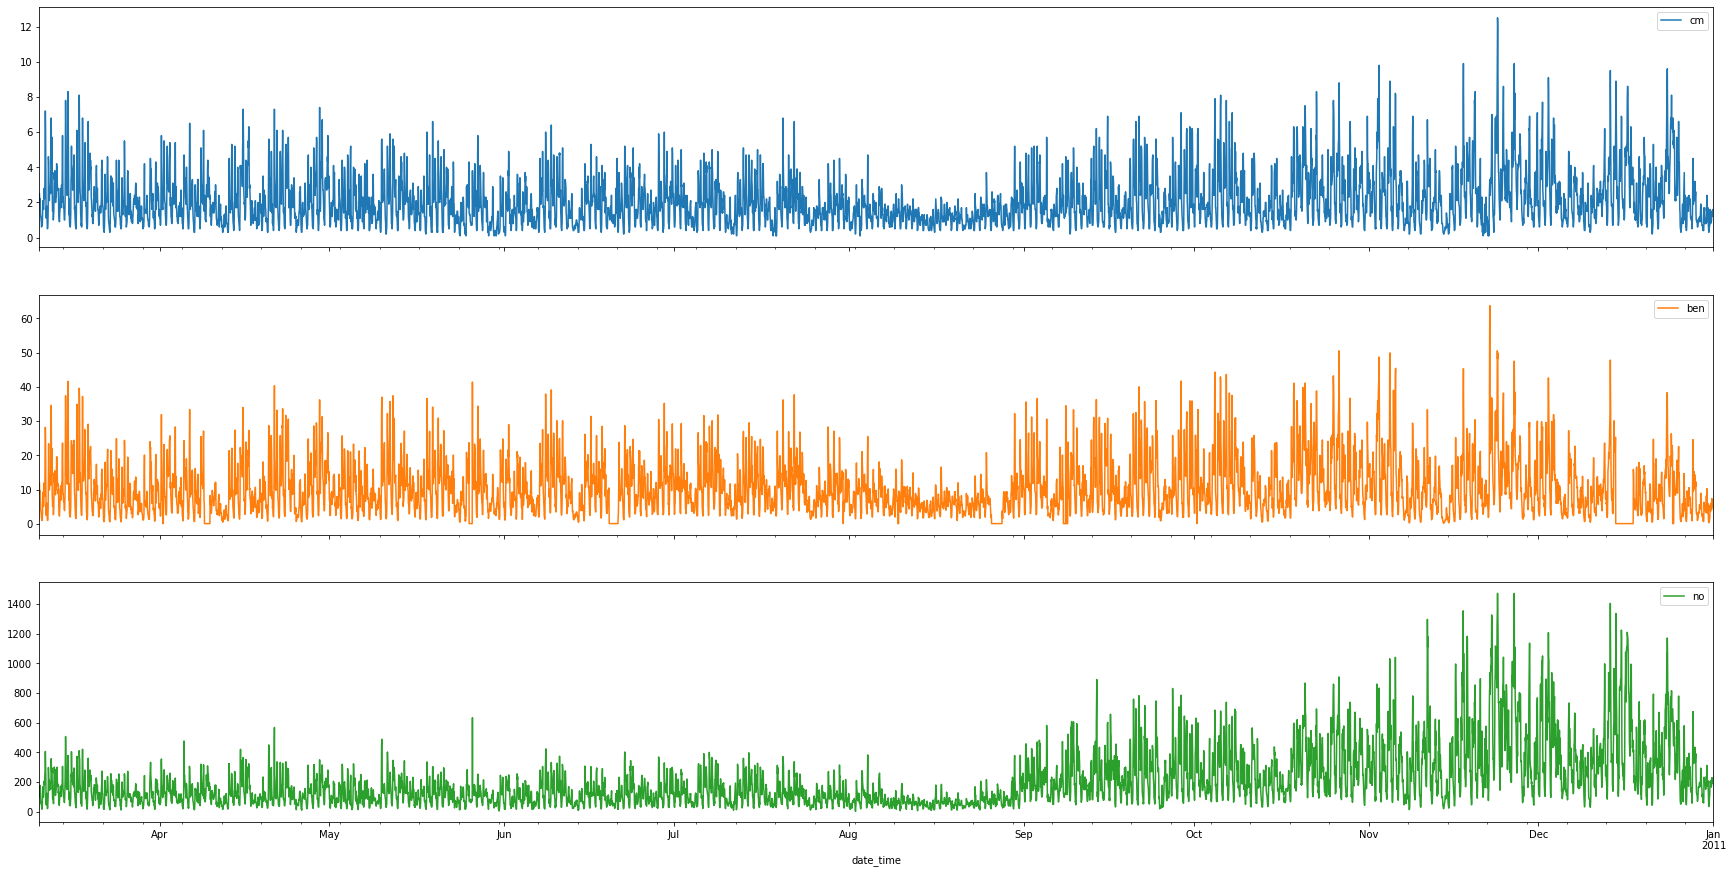

In [8]:
train_u.plot(
    subplots = True, 
    layout = (3,1), 
    sharex = True, 
    figsize = (30,15) )

Plotting all the target together made me realise that the pollutants all share a same pattern. Toward the end the their respective values have increased, may be an over all increase in the trend. 


In [9]:
# Separately performing each target variable.
# Purpose of train_cm is to decide for the model parameters later

train_cm = train_u.copy()
train_cm.drop(columns = ['ben','no'], inplace = True)
train_cm.tail()

,cm
date_time,
2010-12-31 20:00:00,1.3
2010-12-31 21:00:00,1.4
2010-12-31 22:00:00,1.6
2010-12-31 23:00:00,1.5
2011-01-01 00:00:00,1.4


<AxesSubplot:xlabel='date_time'>

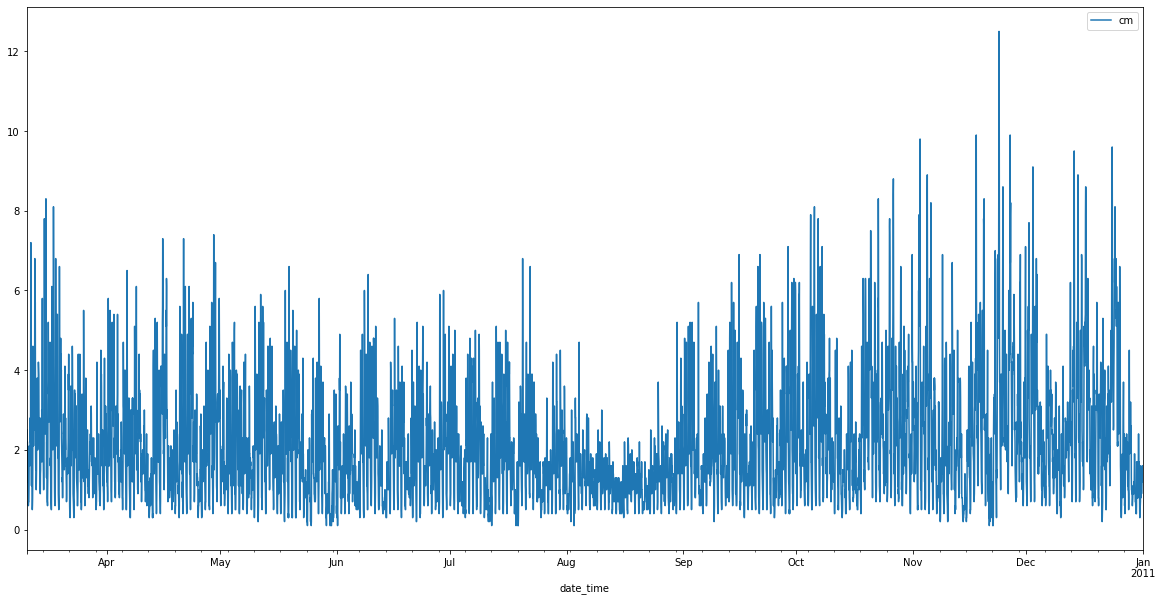

In [10]:
train_cm.plot(figsize = (20,10))

## Stationarity in the data

In [11]:
# Testing For Stationarity
from statsmodels.tsa.stattools import adfuller


#Ho: It is non stationary
#H1: It is stationary
def adfuller_test(levels):
    result=adfuller(levels)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("\n strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("\n weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [12]:
adfuller_test(train_cm['cm'])

ADF Test Statistic : -8.982102584772074
p-value : 7.263413572493433e-15
#Lags Used : 33
Number of Observations Used : 7077

 strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


## AR / MA ? model parameters


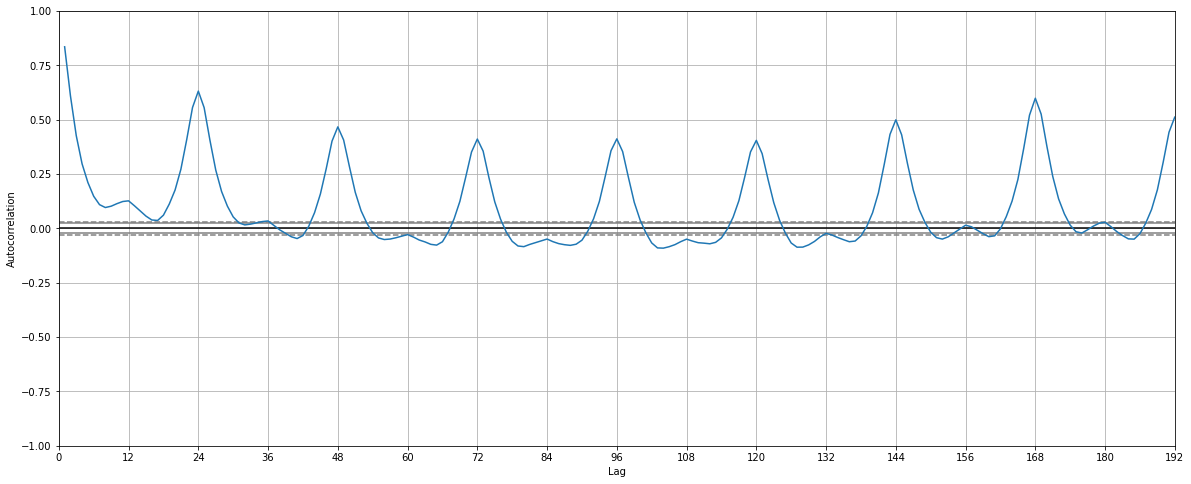

In [13]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(20,8))
autocorrelation_plot(train_cm['cm']).set_xlim([0,100]) # setting the limit to a managable level
plt.xticks(np.arange(0, 200, 12)) # changing the tick frequency for matplotlib
plt.show()

The data is repeating every 24 lags, thus a seasonal pattern observed that can be used in the model preparation later.
* Next would be to get the ACF and PACF analysed for the TSA model

In [14]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

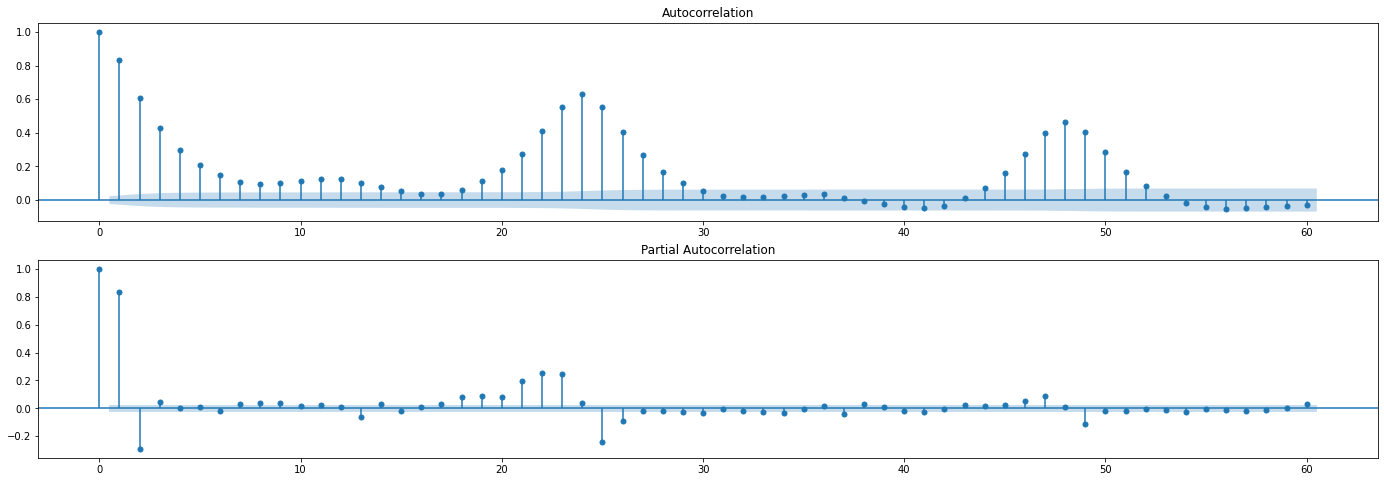

In [15]:
# AR(p) or MA(q) based on the ACF and PACF graphs without accounting for the cyclic nature

fig = plt.figure(figsize=(24,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_cm['cm'], lags = 60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_cm['cm'], lags=60, ax=ax2)

* From the ACF plot, a seasonality/cyclic nature of 24 is again observed
* PACF = P = 1 or 2 for sure. 
* Need to removed the pattern by differencing with a 24 moving window format

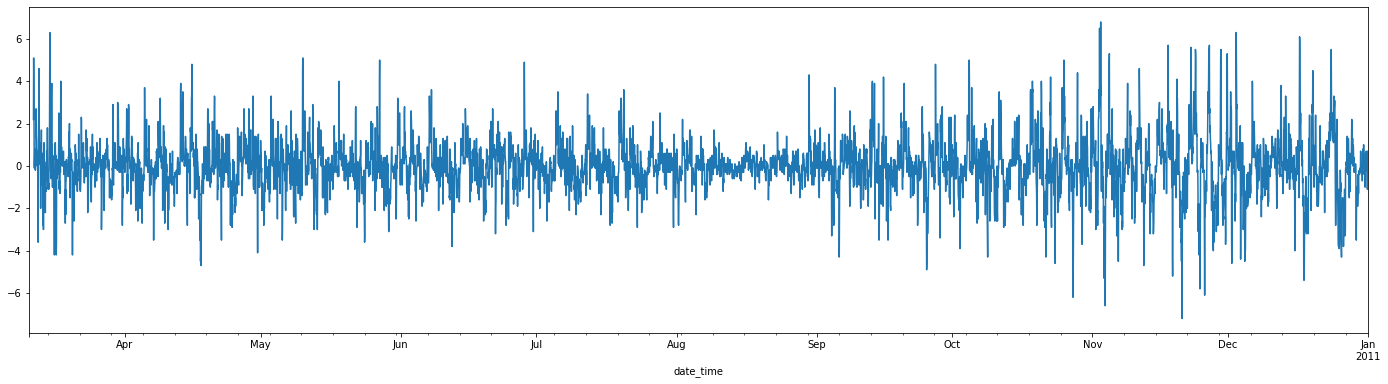

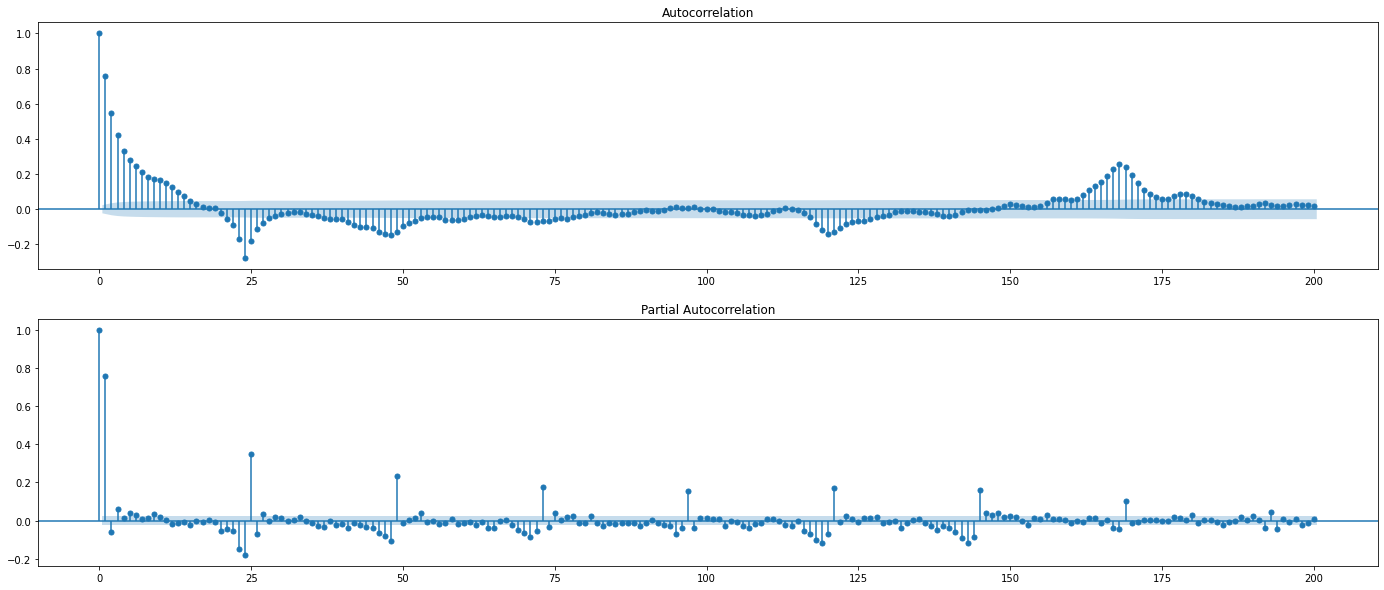

In [16]:
train_cm['diff'] = train_cm['cm'] - train_cm['cm'].shift(24)
train_cm['diff'].plot(figsize = (24,6))

# post differencing 
fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_cm['diff'].iloc[24:], lags = 200, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_cm['diff'].iloc[24:],lags = 200, ax=ax2)

For the sARIMA model, since there is seasonality observed
* AR(p) = can be 1 or strecthed to 2, since post that the correlation values drops in the PACF plot
* d = 1, since the differencing has been conducted once 
* MA(q) = is 1 since the inertia of that is carried forward to the rest of the values, and it is something that is validated by the ACF plot also.


## Building sARIMA 

### Selecting the order

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be use

<AxesSubplot:xlabel='date_time'>

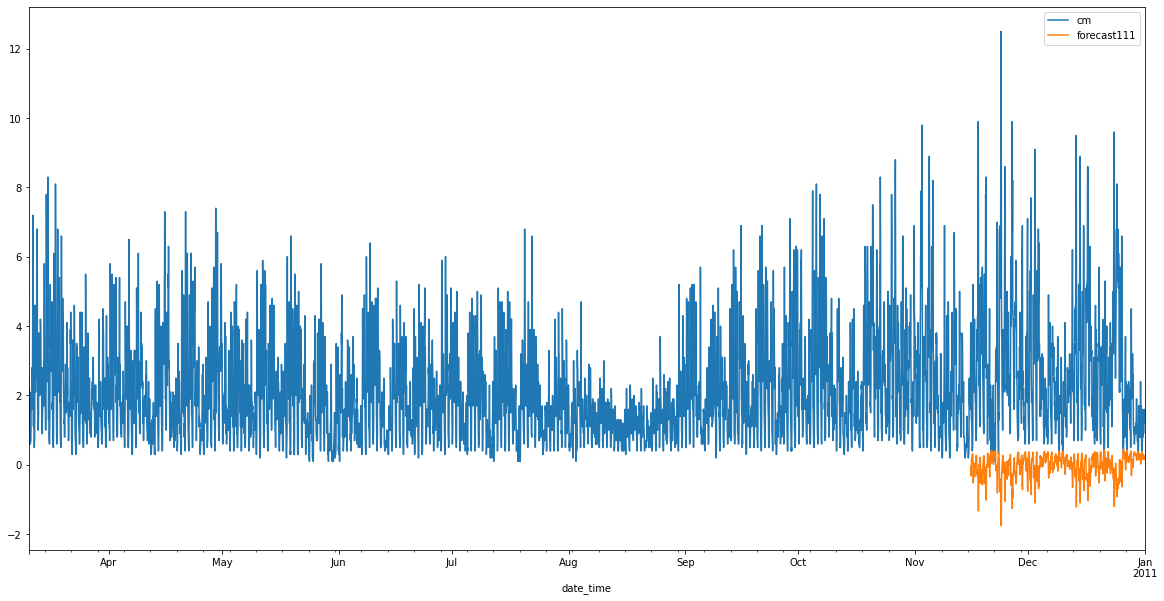

In [17]:
# arima 111
from statsmodels.tsa.arima_model import ARIMA

arima_model = ARIMA(train_cm['cm'],order=(1,1,1))
model_fit = arima_model.fit()
train_cm['forecast111'] = model_fit.predict(start=6000 , end=7110 )
train_cm[['cm','forecast111']].plot(figsize=(20,10))

The fact that forecast is bad proves the initial point of seasonality and the i need to try SARIMA model. 
* Note for this starting project i am just focusing on the traget variables, but in the subsequent notebook will try adding the exogenous variables

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


<AxesSubplot:xlabel='date_time'>

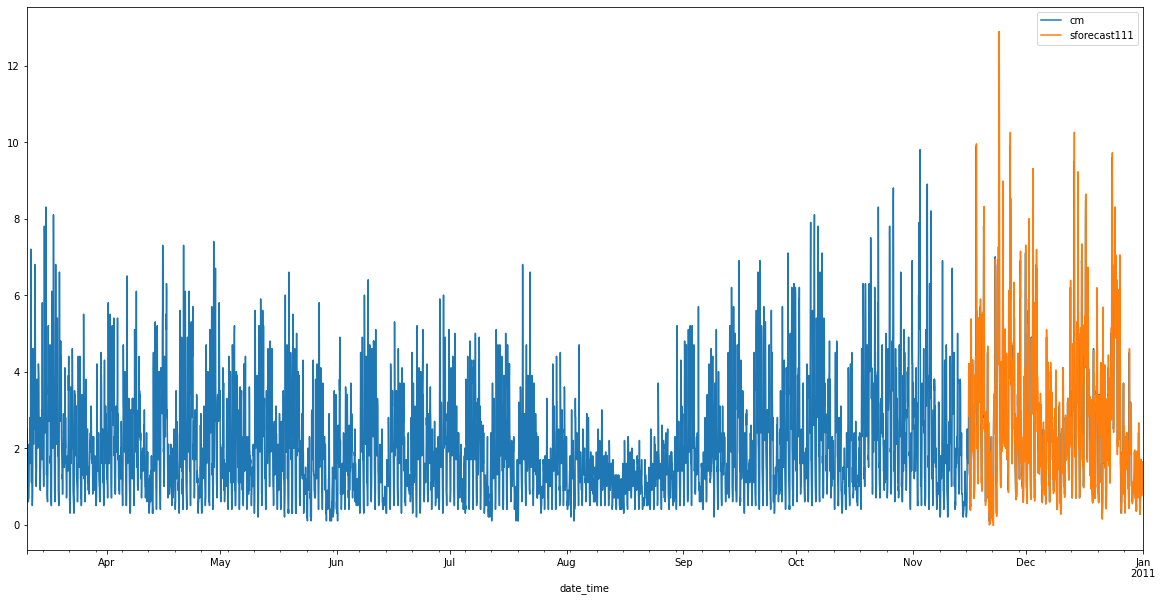

In [18]:
# sarima 111
import statsmodels.api as sm

sarima_model = sm.tsa.statespace.SARIMAX(train_cm['cm'],order=(1, 1, 1))
model_fit = sarima_model.fit()
train_cm['sforecast111'] = model_fit.predict(start=6000 , end=7110 )
train_cm[['cm','sforecast111']].plot(figsize=(20,10))

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


<AxesSubplot:xlabel='date_time'>

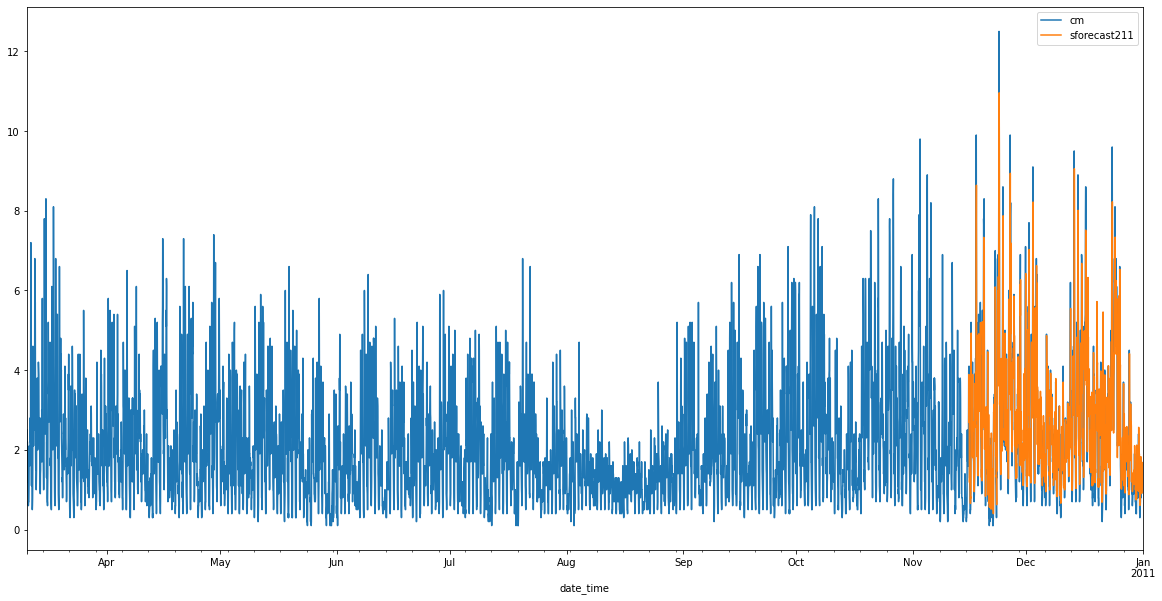

In [19]:
# sarima 211
import statsmodels.api as sm

sarima_model = sm.tsa.statespace.SARIMAX(train_cm['cm'],order=(2, 1, 1))
model_fit = sarima_model.fit()
train_cm['sforecast211'] = model_fit.predict(start=6000 , end=7110 )
train_cm[['cm','sforecast211']].plot(figsize=(20,10))

sARIMA ***111, 211***; all gave promising result compared to arima
* Combined error for the forecast 
* the best model will be applied on the test csv

### Accuracy test

Mean Absolute Percentage Error (MAPE) 
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))

In [20]:
train_cm.columns

Index(['cm', 'diff', 'forecast111', 'sforecast111', 'sforecast211'], dtype='object')

In [21]:
model_111 = np.mean(np.abs(train_cm['forecast111'].iloc[6000:7111] - train_cm['cm'].iloc[6000:7111])/np.abs(train_cm['cm'].iloc[6000:7111]))

model_s111 = np.mean(np.abs(train_cm['sforecast111'].iloc[6000:7111] - train_cm['cm'].iloc[6000:7111])/np.abs(train_cm['cm'].iloc[6000:7111]))

model_s211 = np.mean(np.abs(train_cm['sforecast211'].iloc[6000:7111] - train_cm['cm'].iloc[6000:7111])/np.abs(train_cm['cm'].iloc[6000:7111]))

print(' error - 111',model_111, '\n error - s111', model_s111, '\n error - s211', model_s211)

 error - 111 0.9080854383551029 
 error - s111 0.27304208320019324 
 error - s211 0.3503506839516143


Least error is observed for seasonal arima with 111 model. 
* *There is still room for improvement if the exogenous variables are used in a multivarite Time series analysis*

### Time to predict 

In [22]:
sub = pd.read_csv('../input/tabular-playground-series-jul-2021/sample_submission.csv')

# dataset for univariate analysis

cols = ['target_carbon_monoxide','target_benzene','target_nitrogen_oxides']
sub.drop(cols, axis = 1, inplace = True)
sub

,date_time
0,2011-01-01 00:00:00
1,2011-01-01 01:00:00
2,2011-01-01 02:00:00
3,2011-01-01 03:00:00
4,2011-01-01 04:00:00
...,...
2242,2011-04-04 10:00:00
2243,2011-04-04 11:00:00
2244,2011-04-04 12:00:00
2245,2011-04-04 13:00:00


In [23]:
test = pd.read_csv('../input/tabular-playground-series-jul-2021/test.csv')

# dataset for univariate analysis

cols = ['deg_C', 'relative_humidity', 'absolute_humidity',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']
test.drop(cols, axis = 1, inplace = True)
test

,date_time
0,2011-01-01 00:00:00
1,2011-01-01 01:00:00
2,2011-01-01 02:00:00
3,2011-01-01 03:00:00
4,2011-01-01 04:00:00
...,...
2242,2011-04-04 10:00:00
2243,2011-04-04 11:00:00
2244,2011-04-04 12:00:00
2245,2011-04-04 13:00:00


In [24]:
test

,date_time
0,2011-01-01 00:00:00
1,2011-01-01 01:00:00
2,2011-01-01 02:00:00
3,2011-01-01 03:00:00
4,2011-01-01 04:00:00
...,...
2242,2011-04-04 10:00:00
2243,2011-04-04 11:00:00
2244,2011-04-04 12:00:00
2245,2011-04-04 13:00:00


In [25]:
# cm - sarima 111
import statsmodels.api as sm

sarima_model = sm.tsa.statespace.SARIMAX(train_u['cm'],order=(1, 1, 1))
model_fit = sarima_model.fit(full_output = True)
pre_cm = model_fit.predict(start = pd.to_datetime('2011-01-01 00:00:00'), 
                           end=pd.to_datetime('2011-04-04 14:00:00'), dynamic = False)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [26]:
pre_cm

2011-01-01 00:00:00    1.459063
2011-01-01 01:00:00    1.395532
2011-01-01 02:00:00    1.396463
2011-01-01 03:00:00    1.396269
2011-01-01 04:00:00    1.396309
                         ...   
2011-04-04 10:00:00    1.396302
2011-04-04 11:00:00    1.396302
2011-04-04 12:00:00    1.396302
2011-04-04 13:00:00    1.396302
2011-04-04 14:00:00    1.396302
Freq: H, Name: predicted_mean, Length: 2247, dtype: float64

In [27]:
# ben - sarima 111
import statsmodels.api as sm

sarima_model = sm.tsa.statespace.SARIMAX(train_u['ben'],order=(1, 1, 1))
model_fit = sarima_model.fit()
pre_ben = model_fit.predict(start = pd.to_datetime('2011-01-01 00:00:00'), 
                           end=pd.to_datetime('2011-04-04 14:00:00'), dynamic = False)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [28]:
pre_ben

2011-01-01 00:00:00    4.549334
2011-01-01 01:00:00    4.023940
2011-01-01 02:00:00    4.040030
2011-01-01 03:00:00    4.036626
2011-01-01 04:00:00    4.037347
                         ...   
2011-04-04 10:00:00    4.037221
2011-04-04 11:00:00    4.037221
2011-04-04 12:00:00    4.037221
2011-04-04 13:00:00    4.037221
2011-04-04 14:00:00    4.037221
Freq: H, Name: predicted_mean, Length: 2247, dtype: float64

In [29]:
# no - sarima 111
import statsmodels.api as sm

sarima_model = sm.tsa.statespace.SARIMAX(train_u['no'],order=(1, 1, 1))
model_fit = sarima_model.fit()
pre_no = model_fit.predict(start = pd.to_datetime('2011-01-01 00:00:00'), 
                           end=pd.to_datetime('2011-04-04 14:00:00'), dynamic = False)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [30]:
pre_no

2011-01-01 00:00:00    196.101726
2011-01-01 01:00:00    185.477638
2011-01-01 02:00:00    185.553997
2011-01-01 03:00:00    185.548294
2011-01-01 04:00:00    185.548720
                          ...    
2011-04-04 10:00:00    185.548690
2011-04-04 11:00:00    185.548690
2011-04-04 12:00:00    185.548690
2011-04-04 13:00:00    185.548690
2011-04-04 14:00:00    185.548690
Freq: H, Name: predicted_mean, Length: 2247, dtype: float64

In [31]:
final = pd.DataFrame({'cm':pre_cm, 'ben':pre_ben, 'no':pre_no}).reset_index()
final.columns = ['date_time', 'target_carbon_monoxide','target_benzene', 'target_nitrogen_oxides']
final

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.459063,4.549334,196.101726
1,2011-01-01 01:00:00,1.395532,4.023940,185.477638
2,2011-01-01 02:00:00,1.396463,4.040030,185.553997
3,2011-01-01 03:00:00,1.396269,4.036626,185.548294
4,2011-01-01 04:00:00,1.396309,4.037347,185.548720
...,...,...,...,...
2242,2011-04-04 10:00:00,1.396302,4.037221,185.548690
2243,2011-04-04 11:00:00,1.396302,4.037221,185.548690
2244,2011-04-04 12:00:00,1.396302,4.037221,185.548690
2245,2011-04-04 13:00:00,1.396302,4.037221,185.548690


In [32]:
final.to_csv("Submission.csv", index = False)